# EEG preprocessing

In [3]:
import kagglehub
import shutil
import os

import numpy as np
import mne


In [4]:
import mne.io

# Replace 'your_file.gdf' with the path to your GDF file
rawA01T = mne.io.read_raw_gdf('../data/raw/Train/A01T.gdf', preload=True) # Training data


# Rename the channels to more readable names
channel_names = [
    'Fz',  'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5',  'C3',  'C1',  'Cz', 
    'C2',  'C4',  'C6',  'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1',  'Pz', 
    'P2',  'POz', 'EOG-left', 'EOG-central', 'EOG-right'
]

mapping = {old_name: new_name for old_name, new_name in zip(rawA01T.ch_names, channel_names)}
rawA01T.rename_channels(mapping)

# Set EEG channel types
eeg_channel_names = channel_names[:-3]  # All except the last three EOG
rawA01T.set_channel_types({ch_name: 'eeg' for ch_name in eeg_channel_names})
# Set EOG channel types
eog_channel_names = channel_names[-3:]  # Last three channels
rawA01T.set_channel_types({ch_name: 'eog' for ch_name in eog_channel_names})

# Printing exisring channel names
print(rawA01T.ch_names)

# Print information about the loaded data (channels, sampling rate, etc.)
print(rawA01T.info)

Extracting GDF parameters from ../data/raw/Train/A01T.gdf...
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


C:\Users\Prashastha\AppData\Local\Programs\Python\Python313\Lib\contextlib.py:148: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz', 'EOG-left', 'EOG-central', 'EOG-right']
<Info | 8 non-empty values
 bads: []
 ch_names: Fz, FC3, FC1, FCz, FC2, FC4, C5, C3, C1, Cz, C2, C4, C6, CP3, ...
 chs: 22 EEG, 3 EOG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 2005-01-17 12:00:00 UTC
 nchan: 25
 projs: []
 sfreq: 250.0 Hz
 subject_info: <subject_info | his_id: A01, sex: 0, last_name: X, birthday: 1983-01-17>
>


Montage set successfully!


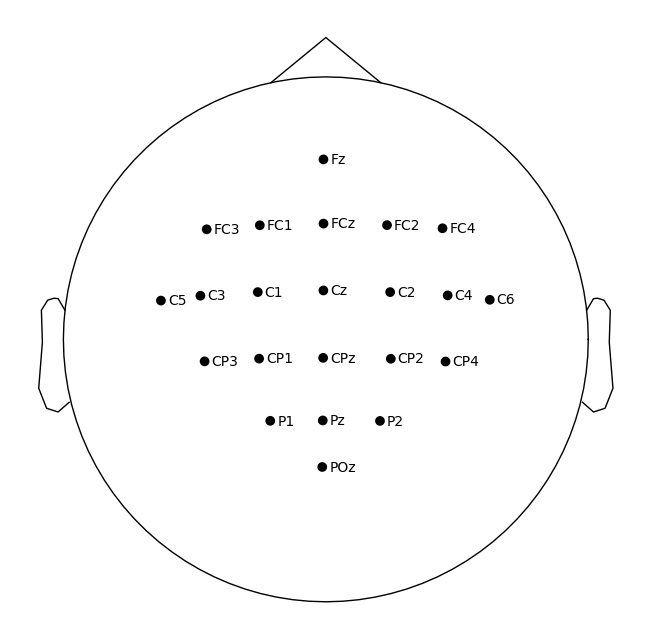

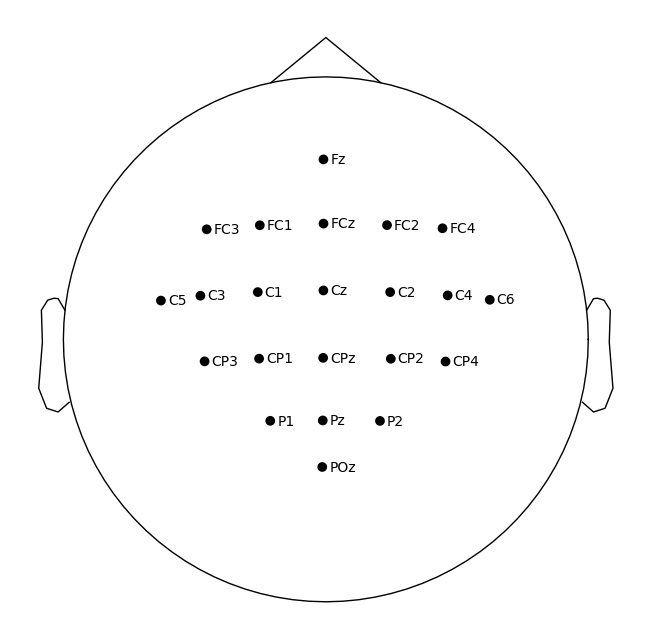

In [5]:
# Get sensor location information
montage = mne.channels.make_standard_montage('standard_1020')
rawA01T.set_montage(montage)

print("Montage set successfully!")
rawA01T.plot_sensors(show_names=True)

In [6]:
# Remove EOG channels
eog_channels = ['EOG-left', 'EOG-central', 'EOG-right']
rawA01T.drop_channels(eog_channels)

<RawGDF | A01T.gdf, 22 x 672528 (2690.1 s), ~112.9 MiB, data loaded>

### Visualise before resampling

Annotations in A01T: ['Start of a new run', 'Idling EEG (eyes open)', 'Start of a new run', 'Idling EEG (eyes closed)', 'Start of a new run', 'Eye movements', 'Start of a new run', 'Start of a trial', 'Cue onset tongue (class 4)', 'Start of a trial', 'Cue onset foot (class 3)', 'Start of a trial', 'Cue onset right (class 2)', 'Start of a trial', 'Cue onset left (class 1)', 'Start of a trial', 'Cue onset left (class 1)', 'Start of a trial', 'Cue onset right (class 2)', 'Start of a trial', 'Cue onset foot (class 3)', 'Start of a trial', 'Cue onset tongue (class 4)', 'Start of a trial', 'Cue onset right (class 2)', 'Start of a trial', 'Cue onset foot (class 3)', 'Start of a trial', 'Cue onset left (class 1)', 'Start of a trial', 'Cue onset left (class 1)', 'Start of a trial', 'Cue onset left (class 1)', 'Start of a trial', 'Cue onset tongue (class 4)', 'Start of a trial', 'Cue onset right (class 2)', 'Start of a trial', 'Cue onset right (class 2)', 'Start of a trial', 'Cue onset left (cla

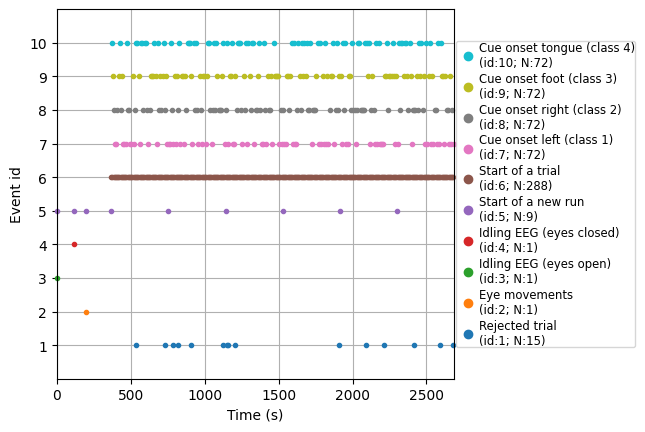

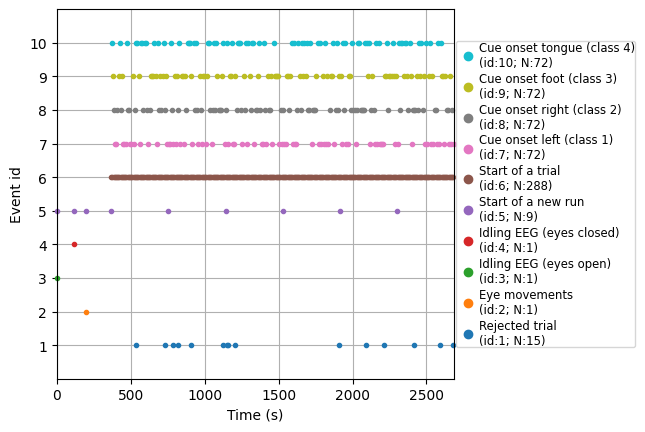

In [7]:
import mne
# create a plot of annotation descriptions over time
annotationsT = rawA01T.annotations.description

# Annotation conversion map
annotation_map = {
    '276': 'Idling EEG (eyes open)',
    '277': 'Idling EEG (eyes closed)',
    '768': 'Start of a trial',
    '769': 'Cue onset left (class 1)',
    '770': 'Cue onset right (class 2)',
    '771': 'Cue onset foot (class 3)',
    '772': 'Cue onset tongue (class 4)',
    '783': 'Cue unknown',
    '1023': 'Rejected trial',
    '1072': 'Eye movements',
    '32766': 'Start of a new run',
}

# Map the annotations to their descriptions
annotationsT = [annotation_map.get(desc, desc) for desc in annotationsT]

# Plot the raw data
print("Annotations in A01T:", annotationsT)

eventsT, event_idT = mne.events_from_annotations(rawA01T)
# Replace event IDs with annotation descriptions
event_idT = {annotation_map.get(str(key), str(key)): value for key, value in event_idT.items()}
mne.viz.plot_events(eventsT, rawA01T.info["sfreq"], event_id=event_idT, show=True)

### Resample dataset from 250 Hz to 128 Hz

In [8]:
# Inital data is sampled at 250Hz
# We will resample it to 128Hz to reduce computational load
rawA01T.resample(128, npad="auto")

<RawGDF | A01T.gdf, 22 x 344334 (2690.1 s), ~57.8 MiB, data loaded>

### Bandpass filter 4~40Hz

In [9]:
# Adding a bandpass filter from 4Hz to 38Hz
rawA01T.filter(4., 38., fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 213 samples (1.664 s)



<RawGDF | A01T.gdf, 22 x 344334 (2690.1 s), ~57.8 MiB, data loaded>

### Exponential moving standardization

electrode-wise exponential moving standardization with a decay factor of 0.999 to compute exponential moving means and
variances for each channel and used these to standardize the continuous data

In [ ]:
# electrode-wise exponential moving standardization with a decay factor of 0.999 
# to compute exponential moving means and variances for each channel and used these to standardize the continuous data

In [10]:
def exponential_moving_standardize(x: np.ndarray, factor_new: float = 0.001, init_block_size: int = 1000) -> np.ndarray:
    """Apply exponential moving standardization to the data.

    Args:
        x: Input data array of shape (n_channels, n_times).
        factor_new: Smoothing factor for the moving average.
        init_block_size: Number of initial samples to use for mean and std calculation.

    Returns:
        Standardized data array of the same shape as input.
    """
    x_std = np.zeros_like(x)
    mean_prev = np.mean(x[:, :init_block_size], axis=1, keepdims=True)
    var_prev = np.var(x[:, :init_block_size], axis=1, keepdims=True)

    for t in range(x.shape[1]):
        sample = x[:, t:t+1]
        mean_curr = (1 - factor_new) * mean_prev + factor_new * sample
        var_curr = (1 - factor_new) * var_prev + factor_new * (sample - mean_curr) ** 2

        x_std[:, t:t+1] = (sample - mean_curr) / np.sqrt(var_curr + 1e-10)

        mean_prev = mean_curr
        var_prev = var_curr

    return x_std

Using matplotlib as 2D backend.


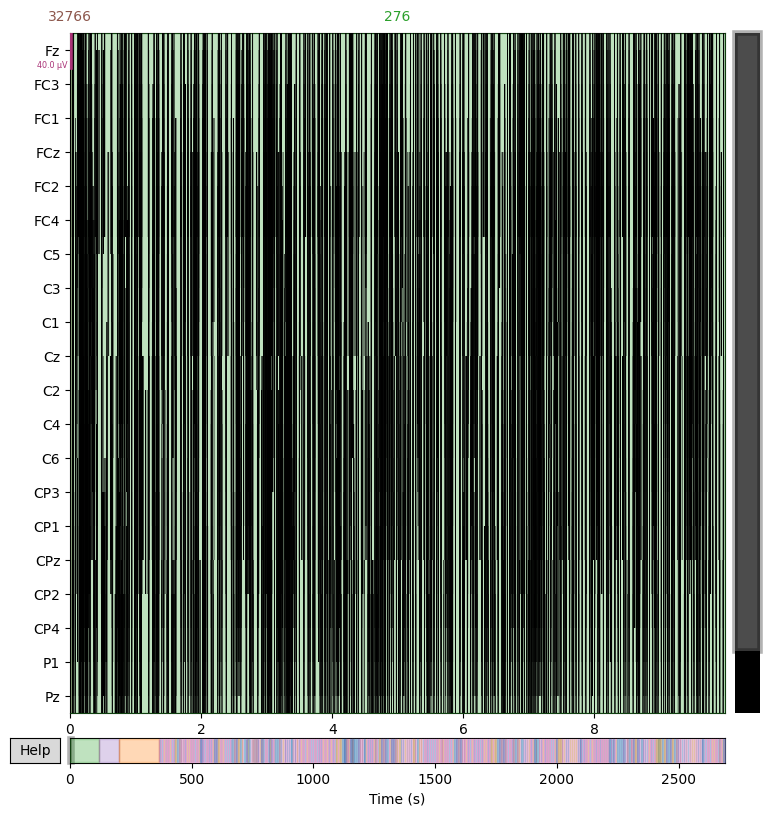

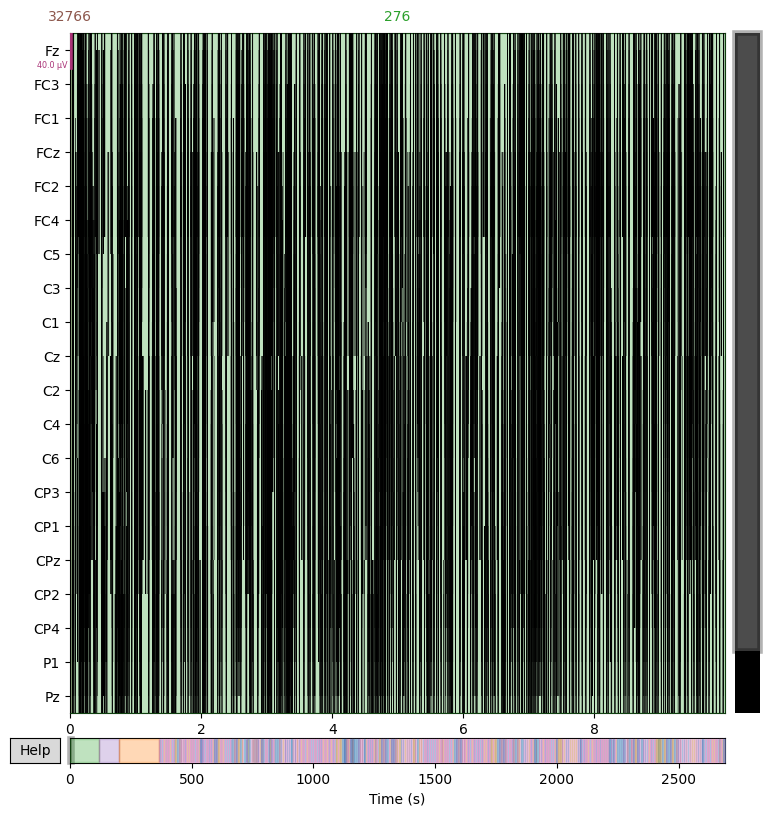

In [11]:
# Apply exponential moving standardization
dataT = rawA01T.get_data()
dataT_std = exponential_moving_standardize(dataT)
rawA01T_std = rawA01T.copy()
rawA01T_std._data = dataT_std
rawA01T_std.plot()


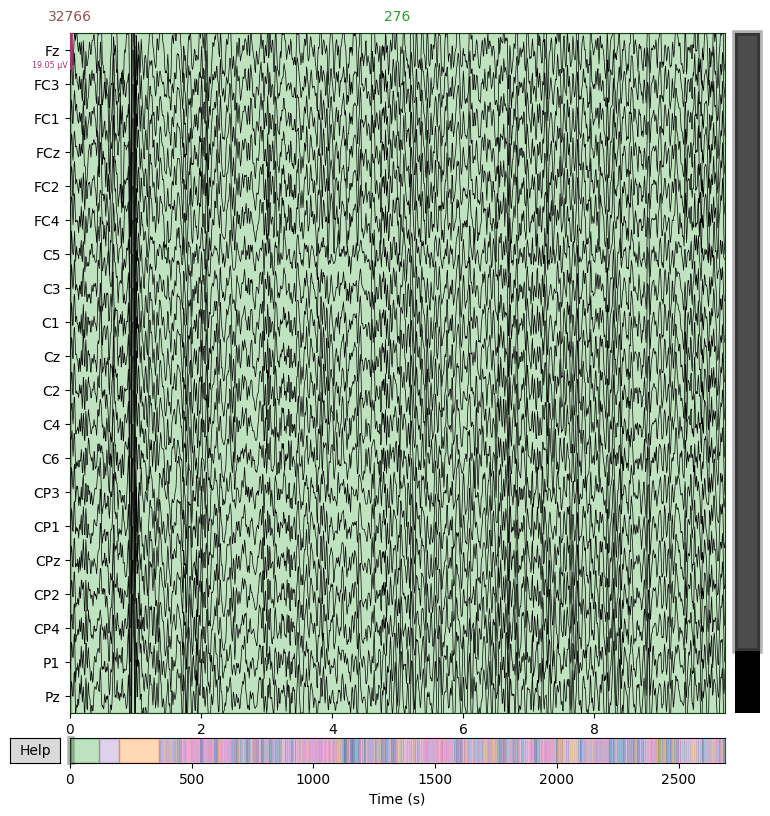

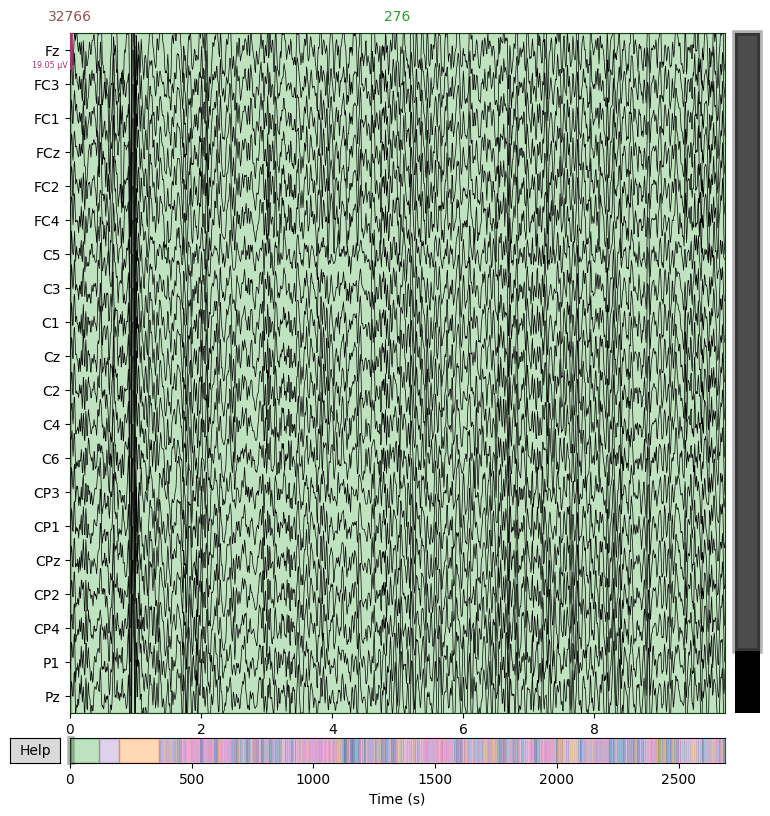

In [12]:
# Plot the raw data to visually inspect it
rawA01T.plot(scalings='auto', title='Raw EEG Data', show=True, block=True)


In [14]:
rawA01T_std.info

<Info | 9 non-empty values
 bads: []
 ch_names: Fz, FC3, FC1, FCz, FC2, FC4, C5, C3, C1, Cz, C2, C4, C6, CP3, ...
 chs: 22 EEG
 custom_ref_applied: False
 dig: 25 items (3 Cardinal, 22 EEG)
 highpass: 4.0 Hz
 lowpass: 38.0 Hz
 meas_date: 2005-01-17 12:00:00 UTC
 nchan: 22
 projs: []
 sfreq: 128.0 Hz
 subject_info: <subject_info | his_id: A01, sex: 0, last_name: X, birthday: 1983-01-17>
>

### Visualise annotations

Annotations in A01T_std: ['Start of a new run', 'Idling EEG (eyes open)', 'Start of a new run', 'Idling EEG (eyes closed)', 'Start of a new run', 'Eye movements', 'Start of a new run', 'Start of a trial', 'Cue onset tongue (class 4)', 'Start of a trial', 'Cue onset foot (class 3)', 'Start of a trial', 'Cue onset right (class 2)', 'Start of a trial', 'Cue onset left (class 1)', 'Start of a trial', 'Cue onset left (class 1)', 'Start of a trial', 'Cue onset right (class 2)', 'Start of a trial', 'Cue onset foot (class 3)', 'Start of a trial', 'Cue onset tongue (class 4)', 'Start of a trial', 'Cue onset right (class 2)', 'Start of a trial', 'Cue onset foot (class 3)', 'Start of a trial', 'Cue onset left (class 1)', 'Start of a trial', 'Cue onset left (class 1)', 'Start of a trial', 'Cue onset left (class 1)', 'Start of a trial', 'Cue onset tongue (class 4)', 'Start of a trial', 'Cue onset right (class 2)', 'Start of a trial', 'Cue onset right (class 2)', 'Start of a trial', 'Cue onset left 

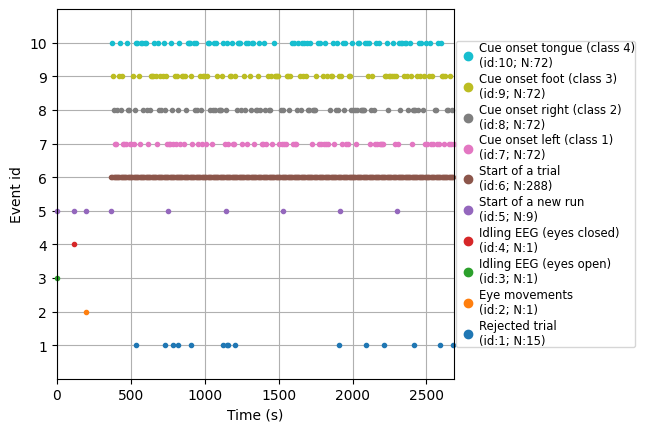

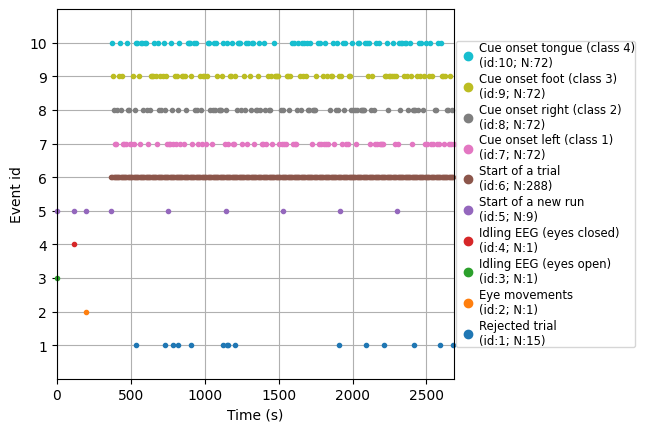

In [15]:
import mne
# create a plot of annotation descriptions over time
annotationsT = rawA01T_std.annotations.description

# Annotation conversion map
annotation_map = {
    '276': 'Idling EEG (eyes open)',
    '277': 'Idling EEG (eyes closed)',
    '768': 'Start of a trial',
    '769': 'Cue onset left (class 1)',
    '770': 'Cue onset right (class 2)',
    '771': 'Cue onset foot (class 3)',
    '772': 'Cue onset tongue (class 4)',
    '783': 'Cue unknown',
    '1023': 'Rejected trial',
    '1072': 'Eye movements',
    '32766': 'Start of a new run',
}

# Map the annotations to their descriptions
annotationsT = [annotation_map.get(desc, desc) for desc in annotationsT]

# Plot the raw data
print("Annotations in A01T_std:", annotationsT)

eventsT, event_idT = mne.events_from_annotations(rawA01T_std)
# Replace event IDs with annotation descriptions
event_idT = {annotation_map.get(str(key), str(key)): value for key, value in event_idT.items()}
mne.viz.plot_events(eventsT, rawA01T_std.info["sfreq"], event_id=event_idT, show=True)

In [ ]:
# Break the data into trial windows (0.5-2.5 seconds cue onset) using cue onset markers 
epocsT_std = mne.Epochs(rawA01T_std, eventsT, event_id={'Cue onset left (class 1)': 7,
                                                        'Cue onset right (class 2)': 8,
                                                        'Cue onset foot (class 3)': 9,
                                                        'Cue onset tongue (class 4)': 10}, tmin=0.5, tmax=2.5, baseline=None, preload=True)

Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 257 original time points ...


0 bad epochs dropped


In [48]:
# Convert epochs to numpy arrays for model input
X_train = epocsT_std.get_data()  # Shape: (n_epochs, n_channels, n_times)
y_train = epocsT_std.events[:, -1]  # Extract labels from events
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)

Training data shape: (288, 22, 257)
Training labels shape: (288,)


In [49]:
# Check how long each epoch is in seconds
epoch_duration = epocsT_std.times[-1] - epocsT_std.times[0]
print("Epoch duration (seconds):", epoch_duration)

Epoch duration (seconds): 2.0


Epoch duration (seconds): 2.0


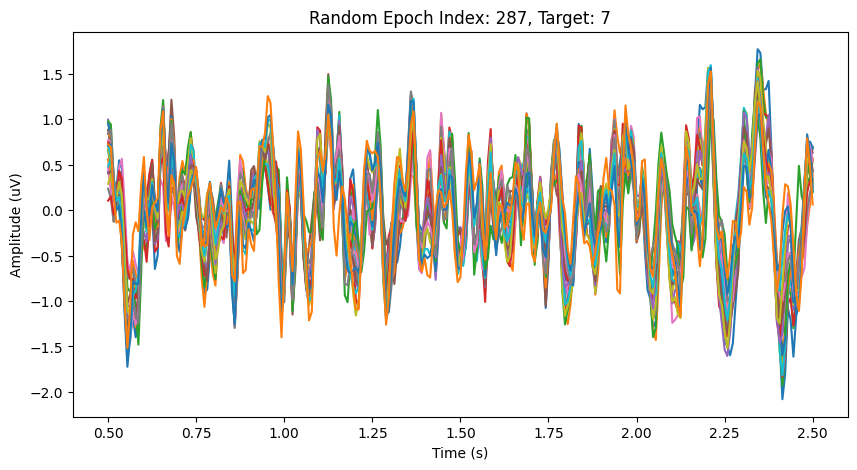

In [56]:
# Plot epoch vs target for a random epochs
epoch_duration = epocsT_std.times[-1] - epocsT_std.times[0]
print("Epoch duration (seconds):", epoch_duration)
import random
import matplotlib.pyplot as plt
n_epochs = X_train.shape[0]
epoch_idx = 287 #random.randint(0, n_epochs - 1)
plt.figure(figsize=(10, 5))
plt.plot(epocsT_std.times, X_train[epoch_idx].T)
plt.title(f'Random Epoch Index: {epoch_idx}, Target: {y_train[epoch_idx]}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.show()

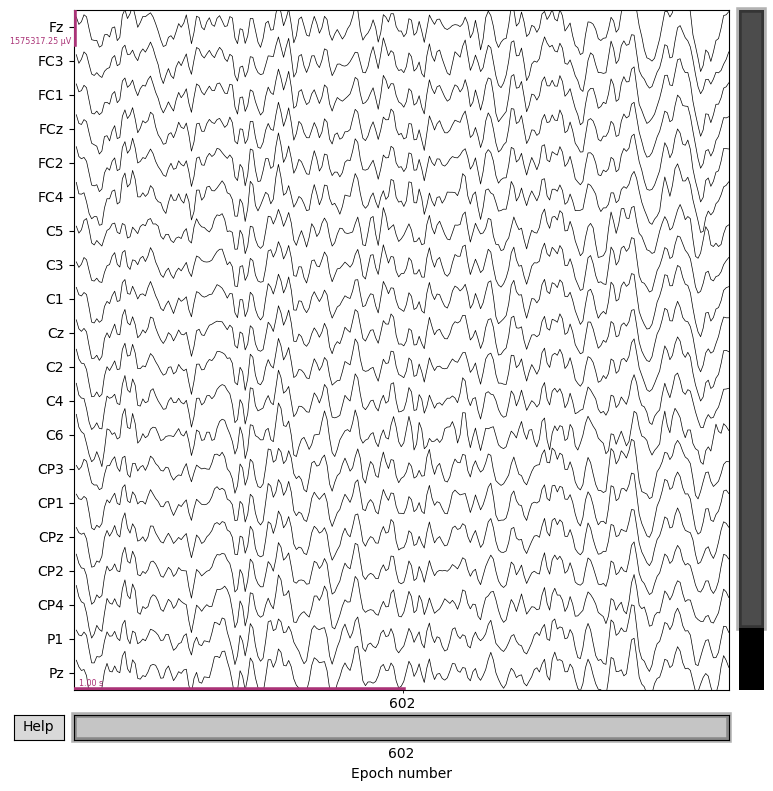

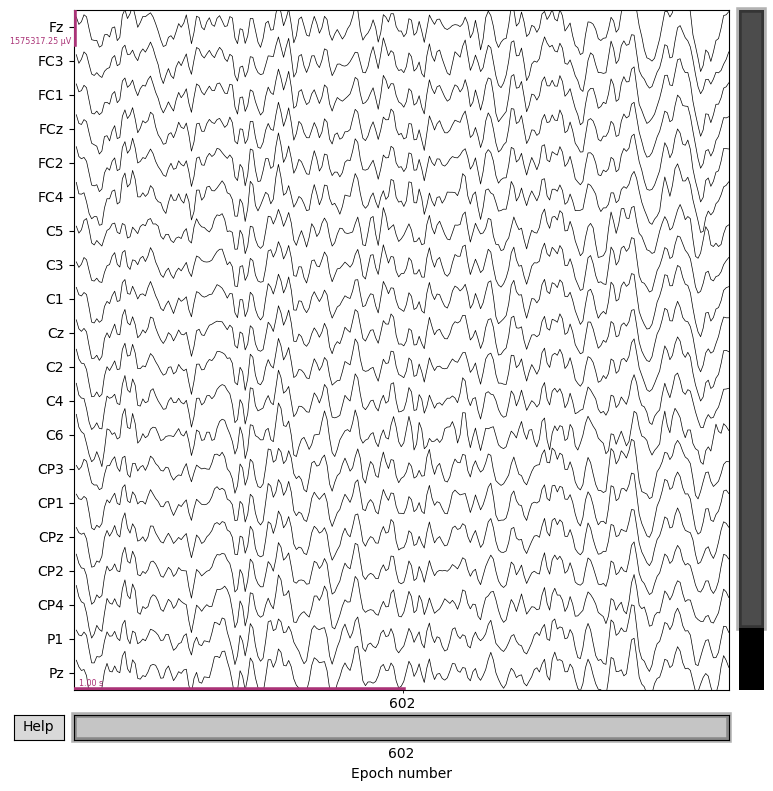

In [57]:
epocsT_std[287].plot(scalings='auto', title='Pre-processed EEG Data', show=True, block=True)